# Importing Liberaries


In [61]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Loading Dataset

In [52]:


# Load dataset
(train_ds, test_ds), ds_info = tfds.load(
    'eurosat/all',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)




# Preprosessing

In [ ]:
# Normalize
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image /= tf.reduce_max(image)
    return image, label


BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE).cache().shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)



# Model Architecture  

In [53]:

model = models.Sequential([
    layers.Input(shape=(64, 64, 13)),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dropout(0.5),  # helps with overfitting

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(ds_info.features['label'].num_classes, activation='softmax')
])


## Compiling the Model

In [54]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


## Fitting

In [55]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=25
)


Epoch 1/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 279s 407ms/step - accuracy: 0.5736 - loss: 1.3760 - val_accuracy: 0.7930 - val_loss: 0.7332
Epoch 2/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 271s 402ms/step - accuracy: 0.8037 - loss: 0.7038 - val_accuracy: 0.8769 - val_loss: 0.5182
Epoch 3/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 300s 370ms/step - accuracy: 0.8506 - loss: 0.5816 - val_accuracy: 0.8563 - val_loss: 0.5828
Epoch 4/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 248s 368ms/step - accuracy: 0.8618 - loss: 0.5492 - val_accuracy: 0.8941 - val_loss: 0.4549
Epoch 5/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 254s 377ms/step - accuracy: 0.8738 - loss: 0.5115 - val_accuracy: 0.9046 - val_loss: 0.4386
Epoch 6/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 254s 376ms/step - accuracy: 0.8916 - loss: 0.4625 - val_accuracy: 0.8998 - val_loss: 0.4447
Epoch 7/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 251s 372ms/step - accuracy: 0.9066 - loss: 0.4195 - val_accuracy: 0.9302 - val_loss: 0.3611
Epoch 8/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 255s 378ms/step - accuracy: 0.9148 -

# Model Evaluation

In [57]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

model.save("eurosat_13band_model.h5")


169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9492 - loss: 0.2838


Test Accuracy: 0.9491


# Visualization

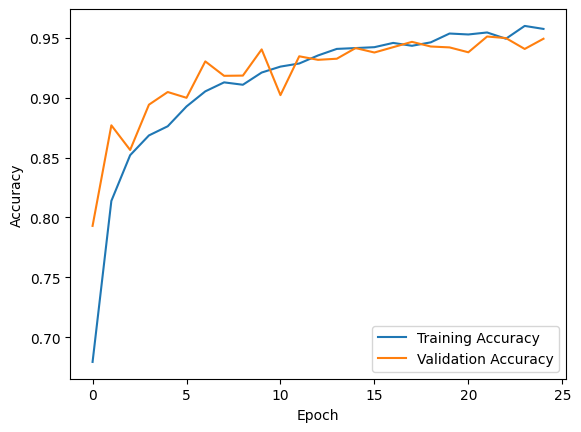

169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.9517 - loss: 0.2764
Test Accuracy: 94.91%


In [58]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Test accuracy
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

In [59]:
import numpy as np

# Get true labels and predicted probabilities
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(model.predict(images, verbose=0))

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.array(y_true)

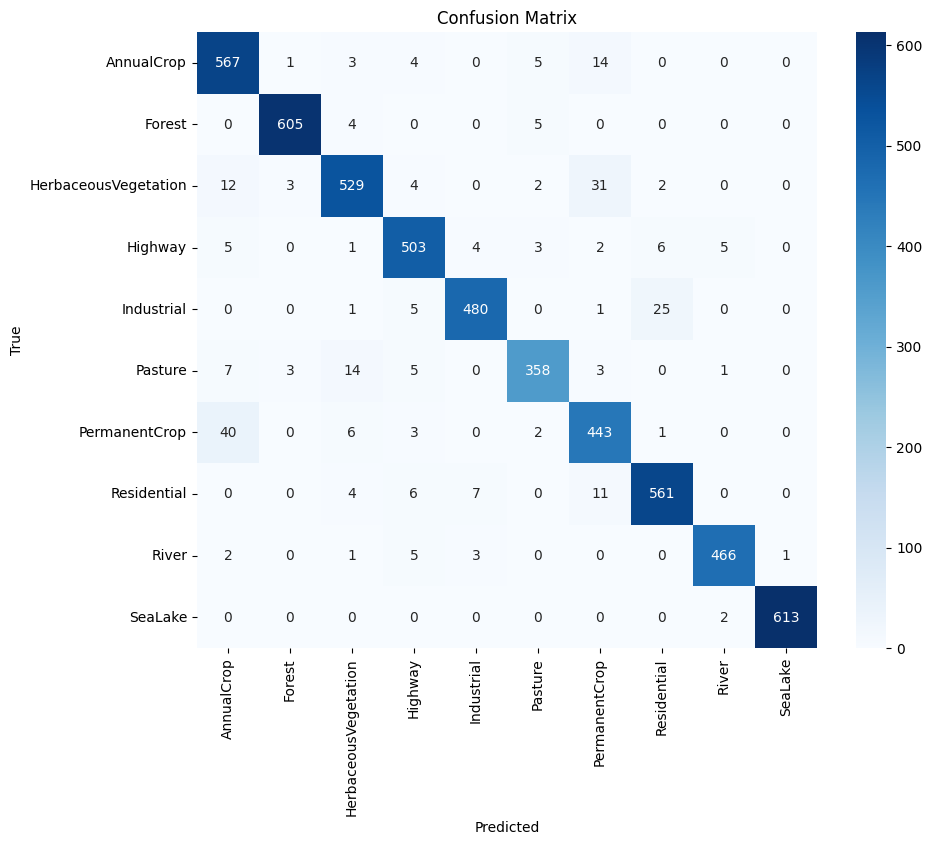

In [60]:


# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()